In [1]:
#| default_exp process

# process

>Image processing submodule

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
#| hide
from nbdev.showdoc import *
from nbdev import *

In [4]:
#| export
import configparser
from fastcore.basics import patch
from os.path import expanduser
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError as ASTTimeoutError
from osob.core import Telescope
from osob.solver import Solver

In [5]:
from IPython import display

In [6]:
import time
from datetime import datetime
import os
from requests import session
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from zipfile import ZipFile
from astropy.io import fits
from astropy.coordinates import SkyCoord, Longitude, Latitude
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import simple_norm
from astroquery.vizier import Vizier
from tqdm.auto import tqdm
rcParams['image.cmap'] = 'gray'

In [7]:
from sqlitedict import SqliteDict

In [8]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

In [9]:
from astropy.visualization import make_lupton_rgb

In [10]:
import astroalign as aa

In [25]:
from osob.aavso import get_VS_sequence

In [11]:
#| local
config = configparser.ConfigParser()
config.read(expanduser('~/.config/telescope.ini'))

['/home/jochym/.config/telescope.ini']

In [12]:
#| local
OSO=Telescope(config['telescope.org']['user'], 
              config['telescope.org']['password'])

In [13]:
#| local
ast = AstrometryNet()
ast.api_key = config['astrometry.net']['apikey']
solver = Solver(config['astrometry.net']['apikey'])

In [14]:
from collections import namedtuple

Job = namedtuple('Job', 'jid rid done')

In [15]:
DB = SqliteDict('telescope.sqlite', autocommit=True)
VS = SqliteDict('vstars.sqlite', autocommit=True)

In [16]:
def make_color_image(layers, black=1.0, Q=5, stretch=200, mults=(0.95, 1.0, 1.0)):
    r, g, b = (m*l for m,l in zip(mults,layers))
    
    try :
        r_r, r_f = aa.register(r, g, detection_sigma=10)
    except TypeError:
        r_r = r
        
    try :
        b_r, b_f = aa.register(b, g, detection_sigma=10)
    except TypeError:
        b_r = b
        
    minlev = array([sigma_clipped_stats(l, sigma=3.0)[1] for l in (r,g,b)])
    return make_lupton_rgb(0.9*r_r, g, b_r, minimum=black*minlev, Q=Q, stretch=stretch)

In [17]:
#| export
def plot_sequence(vs):
    sdb = DB['sequences']
    if vs in sdb:
        seq = sdb[vs]
        if seq[0] is None:
            del sdb[vs]
    else :
        seq = get_VS_sequence(vs, 20, 16.5)
        if seq[0]:
            sdb[vs] = seq
    DB['sequences'] = sdb
    if seq[0] is None:
        return
    ax = gca()
    ax.text(0, 0, seq[0], color='white')
    for s in seq[1]:
        dx = 20/3600
        ax.plot(s[3], s[5], marker=marker, color='C2', ms=30, transform=ax.get_transform('world'))
        ax.text(s[3]+dx, s[5]-dx, s[1], color='white', transform=ax.get_transform('world'))

In [18]:
from matplotlib.path import Path
verts = [
    (0, 0.5),
    (0.3, 0.5),
    (0.7, 0.5),
    (1, 0.5),
]
verts = verts + [(y, x) for x, y in verts]
verts = [(y-0.5, x-0.5) for x, y in verts]
codes = 4*[Path.MOVETO, Path.LINETO]
marker = Path(verts, codes)

In [19]:
def process_job(jid, reprocess=False, cls=True):
    job = OSO.get_job(jid)
    ctime = job['completion']
    req = OSO.get_request(int(job['rid'].split()[0][1:]))
    target = req['name'].lstrip().rstrip()
    print(f'jid {jid}: ({target})')
    print(f'{" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)    
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')
    if not reprocess and jid in DB :
        print('Done')
        if cls:
            display.clear_output(wait=True);
        return
    hi = min(1, len(hdul)-1)
    hi = 0
    wcs_head = solver.solve(hdul[hi], tout=120)
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
        show();
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
#     for g in result:
#         for n, o in enumerate(g):
#             if 'Name' in o.keys():
#                 name = o['Name']
#             elif 'GCVS' in o.keys():
#                 name = ' '.join(o['GCVS'].split())
#             elif 'NSV' in o.keys():
#                 name = f'NSV_{o["NSV"]}'

#             print(f'{name:12} {o["magMax"]:6.2f}', o)
    ax = subplot(projection=w)
    grid(color='white', ls='solid')
    for g in result:
        #print(g)
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            if name.startswith('V0'):
                name = 'V'+name[2:]
            if name in VS:
                jobl = VS[name]
            else :
                jobl = {}
                jobl['jobs']=set()
            jobl['jobs'] |= {jid}
            VS[name]=jobl
            try :
                frame='icrs'
                try :
                    radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                                     frame=frame, unit=(u.hourangle, u.deg))
                except ValueError:
                    radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], 
                                     frame=frame, unit=(u.deg, u.deg))                    
            except KeyError:
                    radec =  SkyCoord(o['_RA.icrs'] + o['_DE.icrs'], 
                                     frame='icrs', unit=(u.hourangle, u.deg))
                    frame='icrs'
#                     radec =  SkyCoord(o['RAB1950'] + o['DEB1950'], 
#                                      frame='fk4', unit=(u.hourangle, u.deg))
            ax.plot(radec.ra.deg, radec.dec.deg, marker=marker, color='C1', ms=30,
                    transform=ax.get_transform('world'), )#edgecolor='yellow', facecolor='none')
            ax.text(radec.ra.deg+0.012, radec.dec.deg-0.012, f'{name} ({o["magMax"]:.1f})', 
                    transform=ax.get_transform('world'), color='white')
            if name.lstrip().rstrip().lower() == target.lower():
                plot_sequence(target)
                
    if cls :
        display.clear_output(wait=True)
        print(f'jid {jid}: ({target})')
        print(f'{" ".join(ctime)}')
        print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')

    try :
        if len(hdul)==3:
            imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul]))
        else :
            data = hdul[hi].data[:-32,:-32]
            imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    except aa.MaxIterError:
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    show()
    display.display(gcf());    

In [62]:
def analyse_job(jid, rid=None, reprocess=False):
    job = OSO.get_job(jid)
    ctime = job['completion']
    if rid is None:
        rid=int(job['rid'].split()[0][1:])
    req = OSO.get_request(rid)
    target = req['name'].lstrip().rstrip()
    print(f'J{jid}:R{rid} ({target}) {" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {" ".join(hdu.header["FILTER"] for hdu in hdul)}')
    if not reprocess and jid in DB:
        print('Done')
        return
    hi = min(1, len(hdul)-1)
    hi = 0
    wcs_head = solver.solve(hdul[hi], tout=120)
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
    for g in result:
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            if name.startswith('V0'):
                name = 'V'+name[2:]
            if name in VS:
                jobl = VS[name]
            else :
                jobl = {}
                jobl['jobs']=set()
                jobl['seq']=None
            try :
                jobl['jobs'] |= {jid}
            except TypeError:
                jobl['jobs'] = {jid}
            if jobl['seq'] is None:
                try :
                    seq = get_VS_sequence(name, 30, 16)
                except ConnectionError:
                    time.sleep(5)
                    seq = get_VS_sequence(name, 30, 16)
                if seq[0] and seq[1]:
                    jobl['seq']=seq
            VS[name]=jobl
            print(f'{name}', end=" ")
            if jobl["seq"] and jobl["seq"][0] and jobl["seq"][1]:
                print(f'seq:{jobl["seq"][0]} ({len(jobl["seq"][1])})')
            else :
                print()                      
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    return True

In [54]:
done = DB['done']
problematic = DB['problematic']

In [30]:
#| local
reqlst=OSO.get_user_requests(sort='completion')
print(f'Number of users requests: {len(reqlst)}')

complete = [rq for rq in sorted(reqlst, key=lambda r: int(r['requesttime']), reverse=True) 
                    if Telescope.REQUESTSTATUS_TEXTS[int(rq['status'])]=='Complete']
print('Completed:', len(complete))

Number of users requests: 1189
Completed: 1172


In [68]:
userjobs = ((int(OSO.get_request(int(j['id']))['jid'][1:]), int(j['id'])) for j in complete)
for n, (jid, rid) in enumerate(userjobs):
    if jid in (problematic | done):
        continue
    print(f"{n}:R{rid}:J{jid}")
    try :
        if analyse_job(jid, rid, True):
            done |= {jid}
    except ConnectionError:
        print('Unable to finish')

60:R680234:J351471
J351471:R680234 (EU Cyg) 14 April 2020 02:58:41 UTC
Filters: R V B
Solving for 1D841881
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solverp13o1alr/tmp5abj3rut.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
61:R679985:J351237
J351237:R679985 (CH Cyg) 29 March 2020 03:01:12 UTC
Filters: R V B
Solving for 7D41D26D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver95c3l43r/tmpsga3g8t6.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
62:R679984:J351236
J351236:R679984 (S Ori) 5 March 2020 21:28:52 UTC
Filters: R V B
Solving for 03DE0E53
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverebm9easa/tmpc22hyfzh.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
63:R679782:J351040
J351040:R679782 (V686 Cyg) 7 March 2020 05:38:13 UTC
Filters: R V B
Solving for 46F3EBF6
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver6nwvxphl/tmp264xg7lv.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
64:R679781:J351039
J351039:R679781 (IP Cyg) 7 March 2020 05:51:38 UTC
Filters: R V B
Solving for CDA98E7D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solvernqthzeeh/tmp_krxndiq.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
65:R679721:J350980
J350980:R679721 (DQ Vul) 4 March 2020 05:54:27 UTC
Filters: R V B
Solving for 1E89E6A7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverkd8kvlis/tmpm0km3vbl.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
66:R679720:J350979
J350979:R679720 (DX Vul) 3 March 2020 06:26:27 UTC
Filters: R V B
Solving for 141E6B1C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverj4yw16ji/tmpd0uoxhkc.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
67:R679719:J350978
J350978:R679719 (EU Cyg) 4 March 2020 06:19:58 UTC
Filters: R V B
Solving for CF9FBECA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solver7w7k1zqf/tmpe0ejkznz.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
68:R679718:J350977
J350977:R679718 (S Ori) 1 March 2020 22:06:47 UTC
Filters: R V B
Solving for 011FE3A0
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver27k27ym0/tmpoqgukq8b.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
69:R679380:J350683
J350683:R679380 (BI Her) 3 March 2020 05:41:04 UTC
Filters: R V B
Solving for BE415E40
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver42y078f4/tmpws3axegi.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
70:R679379:J350682
J350682:R679379 (CH Cyg) 2 March 2020 06:06:49 UTC
Filters: R V B
Solving for 22FAC132
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverr4hh03xb/tmpqm9sqceu.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
71:R679248:J350557
J350557:R679248 (V686 Cyg) 1 March 2020 05:56:36 UTC
Filters: R V B
Solving for 58AEAE35
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver7st5ciyu/tmp3lm4hsli.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
72:R679209:J350523
J350523:R679209 (DQ Vul) 29 February 2020 05:51:14 UTC
Filters: R V B
Solving for D6D584F3
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverl5cj4zhz/tmplfjmzj4i.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
73:R679207:J350521
J350521:R679207 (IP Cyg) 1 March 2020 05:46:42 UTC
Filters: R V B
Solving for 9CC0367E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver09tizfi2/tmp1rvkm4_t.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
74:R679208:J350522
J350522:R679208 (BI Her) 22 February 2020 03:58:51 UTC
Filters: R V B
Solving for E1458BF0
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver97o1so5v/tmp4jm9pd31.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
75:R679206:J350520
J350520:R679206 (EU Cyg) 29 February 2020 06:01:12 UTC
Filters: R V B
Solving for E2417490
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solver022dbtbw/tmpu4_b6chx.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
76:R679205:J350519
J350519:R679205 (CH Cyg) 22 February 2020 04:56:53 UTC
Filters: R V B
Solving for 5B0D3A67
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver1bvhi32b/tmpvoen2iwl.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
77:R679204:J350518
J350518:R679204 (S Ori) 28 February 2020 21:39:29 UTC
Filters: R V B
Solving for 19869B2F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver1ok2ygif/tmp4a3jxtb1.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
78:R678936:J350267
J350267:R678936 (CH Cyg) 20 February 2020 05:24:09 UTC
Filters: R V B
Solving for 1A7A6014
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver3_kwcyft/tmpdslqlhjr.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
79:R678782:J350130
J350130:R678782 (LX Cyg) 13 April 2020 04:22:32 UTC
Filters: R V B
Solving for 654F0EFA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solver2623x3n8/tmp1lrqgk7n.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
NSV_13959 
80:R678780:J350128
J350128:R678780 (V686 Cyg) 21 February 2020 05:50:23 UTC
Filters: R V B
Solving for 2D022CF4
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver1j5g9yoe/tmp2aldckj3.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
81:R678781:J350129
J350129:R678781 (EQ Lyr) 20 February 2020 05:20:12 UTC
Filters: R V B
Solving for 4EB00EC7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverld_ky4yn/tmp0justwt2.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
82:R678712:J350067
J350067:R678712 (EQ Lyr) 16 February 2020 05:36:58 UTC
Filters: R V B
Solving for 451258C8
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver1heerysk/tmpdolio9wg.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
83:R678711:J350066
J350066:R678711 (BI Her) 17 February 2020 04:35:02 UTC
Filters: R V B
Solving for 8DD281C4
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solveruxnjz5xf/tmph7qlhg65.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
84:R678710:J350065
J350065:R678710 (IP Cyg) 20 February 2020 06:16:27 UTC
Filters: R V B
Solving for 07696471
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solverjkaoe3pg/tmp1zk9yasn.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
85:R678661:J350019
J350019:R678661 (CH Cyg) 16 February 2020 05:19:39 UTC
Filters: SII Halpha OIII
Solving for CAA28697
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 85.241667 -4 -2.423889 -5 5 /tmp/field-solveresfannb6/tmp_d7pofgn.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V605 Ori seq:X26834H (9)
V607 Ori seq:X26834I (7)
V608 Ori seq:X26834J (7)
V610 Ori 
V611 Ori 
V612 Ori 
V615 Ori 
V616 Ori 
V619 Ori 
V2754 Ori seq:X26834Q (6)
NSV_02538 
NSV_02547 
NSV_02554 
NSV_02555 
NSV_02559 
NSV_02577 
NSV_02578 
NSV_16635 
NSV_16636 
86:R678545:J349908
J349908:R678545 (EU Cyg) 20 February 2020 06:06:32 UTC
Filters: R V B
Solving for 19901A2A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solverq1dfbqh8/tmpdpy7zf63.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
87:R678504:J349868
J349868:R678504 (BI Her) 14 February 2020 06:06:04 UTC
Filters: R V B
Solving for A6FEF31C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver7_a9_30b/tmpl15qnsyl.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
88:R678503:J349867
J349867:R678503 (V686 Cyg) 16 February 2020 06:14:38 UTC
Filters: R V B
Solving for E3989C23
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solverki8l1l7a/tmpknlopmf4.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
89:R678434:J349803
J349803:R678434 (EQ Lyr) 14 February 2020 05:40:24 UTC
Filters: R V B
Solving for F2FE66BE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverwirgds_a/tmp0xk_19hl.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
90:R678433:J349802
J349802:R678433 (IP Cyg) 14 February 2020 06:23:49 UTC
Filters: R V B
Solving for 286DD7CF
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver3w67rwg1/tmpz4mfsn3r.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
91:R678431:J349800
J349800:R678431 (S Ori) 19 February 2020 21:50:08 UTC
Filters: R V B
Solving for 771D2B60
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver1_jfrt1j/tmpkdgyjr96.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
92:R678432:J349801
J349801:R678432 (CH Cyg) 13 February 2020 05:34:47 UTC
Filters: R V B
Solving for 122E0CBB
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver169_87h_/tmpgysqx77h.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
93:R678376:J349754
J349754:R678376 (EU Cyg) 12 February 2020 06:34:33 UTC
Filters: R V B
Solving for 5DF439D8
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solvert73rkekq/tmpcdbx5ni4.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
94:R678345:J349728
J349728:R678345 (EQ Lyr) 10 February 2020 06:35:30 UTC
Filters: R V B
Solving for 05EC1EE3
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverdsnfmmtw/tmp7ceqondg.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
95:R678344:J349727
J349727:R678344 (BI Her) 11 February 2020 04:55:13 UTC
Filters: R V B
Solving for 26582085
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver1rpe_dco/tmpa6kbrkag.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
96:R678342:J349725
J349725:R678342 (CH Cyg) 10 February 2020 06:45:45 UTC
Filters: R V B
Solving for D1E24970
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver20dt1kuk/tmpbdsradbi.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
97:R678343:J349726
J349726:R678343 (V686 Cyg) 11 February 2020 06:28:50 UTC
Filters: R V B
Solving for E375BB0D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solverycofld1h/tmpkggxe_5o.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
98:R678192:J349589
J349589:R678192 (IP Cyg) 10 February 2020 06:56:53 UTC
Filters: R V B
Solving for AE8D8930
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solveroj6pjtcg/tmp9p9ji4t3.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
99:R678191:J349588
J349588:R678191 (EU Cyg) 9 February 2020 06:45:32 UTC
Filters: R V B
Solving for 237F7444
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solver7bezts6n/tmpsah2p5jk.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
100:R678129:J349535
J349535:R678129 (EQ Lyr) 8 February 2020 06:18:24 UTC
Filters: R V B
Solving for 7119BF1F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverih87w00k/tmpgly9w0tp.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
101:R678128:J349534
J349534:R678128 (BI Her) 8 February 2020 04:54:56 UTC
Filters: R V B
Solving for FBB386F4
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverl0omsbiy/tmpr_vnggd1.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
102:R678127:J349533
J349533:R678127 (CH Cyg) 8 February 2020 05:49:19 UTC
Filters: R V B
Solving for C4F76B14
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solvervkof2vd4/tmpgwp8dktn.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
103:R677870:J349295
J349295:R677870 (EQ Lyr) 6 February 2020 06:23:59 UTC
Filters: R V B
Solving for 66EF78AF
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverxzxq5zxy/tmpmww7y6o0.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
104:R677869:J349294
J349294:R677869 (CH Cyg) 6 February 2020 06:55:00 UTC
Filters: R V B
Solving for D58EA7EB
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverljzaqq41/tmpvxzcgo08.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
105:R677758:J349186
J349186:R677758 (EQ Lyr) 3 February 2020 06:27:56 UTC
Filters: R V B
Solving for 776E5B44
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver39ooauty/tmp49s8fbr3.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
106:R677757:J349185
J349185:R677757 (BI Her) 6 February 2020 05:28:14 UTC
Filters: R V B
Solving for 74140D9A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver1vnu7sgx/tmpus18sbb4.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
107:R677756:J349184
J349184:R677756 (CH Cyg) 3 February 2020 06:13:32 UTC
Filters: R V B
Solving for F2546AE5
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverencj6x0s/tmpsjhwmn9k.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
108:R677755:J349183
J349183:R677755 (S Ori) 10 February 2020 21:54:53 UTC
Filters: R V B
Solving for E5DB14C2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverrqhks_fg/tmp3yiucwne.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
109:R677464:J348897
J348897:R677464 (EQ Lyr) 1 February 2020 06:33:02 UTC
Filters: R V B
Solving for 90D03CE6
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver_snx_3zb/tmp8b9616nu.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
110:R677463:J348896
J348896:R677463 (BI Her) 1 February 2020 05:57:15 UTC
Filters: R V B
Solving for 04BBDF77
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver1r66mc8e/tmpeeoe0ouz.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
111:R677462:J348895
J348895:R677462 (CH Cyg) 1 February 2020 06:16:47 UTC
Filters: R V B
Solving for 568F80B7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver1idoo3no/tmp_e69hmae.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
112:R677461:J348894
J348894:R677461 (S Ori) 2 February 2020 01:25:27 UTC
Filters: R V B
Solving for 7081F35C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solvern_9ni5iu/tmpg_hdoxy4.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
113:R677224:J348665
J348665:R677224 (EQ Lyr) 30 January 2020 06:39:23 UTC
Filters: R V B
Solving for 7CC10581
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver34ccu0x1/tmpmzg5cgtf.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
114:R677223:J348664
J348664:R677223 (BI Her) 31 January 2020 05:25:00 UTC
Filters: R V B
Solving for F731648C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver9ffip3d9/tmpz87ilqrn.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
115:R677222:J348663
J348663:R677222 (CH Cyg) 30 January 2020 06:29:26 UTC
Filters: R V B
Solving for FF37CBF4
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver64w_u9ij/tmpm0c5syam.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
116:R677007:J348461
J348461:R677007 (EQ Lyr) 29 January 2020 06:54:14 UTC
Filters: R V B
Solving for 1FC52ECD
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverkgy_kqob/tmplkd7tw28.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
117:R677006:J348460
J348460:R677006 (BI Her) 29 January 2020 05:56:52 UTC
Filters: R V B
Solving for D6D40CF9
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver6ogk312y/tmpb6m1xenr.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
118:R677004:J348458
J348458:R677004 (S Ori) 30 January 2020 23:14:24 UTC
Filters: R V B
Solving for C575745C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver6mxugu21/tmp0tpirmlo.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
119:R677005:J348459
J348459:R677005 (CH Cyg) 29 January 2020 06:44:11 UTC
Filters: R V B
Solving for 8FB394DF
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solveryzzffc82/tmp_aiacmyb.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
120:R676869:J348337
J348337:R676869 (BI Her) 28 January 2020 05:39:04 UTC
Filters: R V B
Solving for F3214BC7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver7_yjjb9_/tmpduyx2ut1.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
121:R676732:J348212
J348212:R676732 (BI Her) 27 January 2020 05:38:58 UTC
Filters: R V B
Solving for 11FD81DA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverf4i3qytk/tmp12dijs6g.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
122:R676733:J348213
J348213:R676733 (EQ Lyr) 28 January 2020 06:51:51 UTC
Filters: R V B
Solving for 2095C86F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solvermb120891/tmpr8wawq8w.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
123:R676731:J348211
J348211:R676731 (CH Cyg) 28 January 2020 06:33:46 UTC
Filters: R V B
Solving for 8ECCCBB8
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver4p_p54u7/tmpvbiujkfg.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
124:R676730:J348210
J348210:R676730 (S Ori) 28 January 2020 01:56:03 UTC
Filters: R V B
Solving for 0DC42B73
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverlqbej372/tmpg9hpj5yb.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
125:R676361:J347878
J347878:R676361 (BI Her) 25 January 2020 06:41:31 UTC
Filters: R V B
Solving for B7D90485
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver34wkvzty/tmpj20q6tdu.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
126:R676360:J347877
J347877:R676360 (CH Cyg) 25 January 2020 06:57:47 UTC
Filters: R V B
Solving for C5FC5E20
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver_en_2ko0/tmp4yhj2j_m.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
127:R676261:J347780
J347780:R676261 (BI Her) 21 January 2020 06:53:02 UTC
Filters: R V B
Solving for CB5A302A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver_fgz9to6/tmp7x64bqed.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
128:R676102:J347625
J347625:R676102 (BI Her) 20 January 2020 06:14:22 UTC
Filters: R V B
Solving for 28FA5F1B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverlddmqtwj/tmp89sm2ne5.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
129:R676101:J347624
J347624:R676101 (SS Cyg) 13 April 2020 04:11:17 UTC
Filters: R V B
Solving for 5A959374
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver8jtbsqml/tmp8570qzr2.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
130:R676100:J347623
J347623:R676100 (S Ori) 25 January 2020 00:25:55 UTC
Filters: R V B
Solving for F73F5577
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverluke7efz/tmph4ls6rfr.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
131:R675932:J347464
J347464:R675932 (BI Her) 19 January 2020 06:27:04 UTC
Filters: R V B
Solving for 55D79166
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverj4wksdkf/tmpj3ksn839.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
132:R675782:J347318
J347318:R675782 (BI Her) 18 January 2020 06:17:37 UTC
Filters: R V B
Solving for FF011BC6
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solvermp6qmjsk/tmpyfrwvyh0.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
133:R675781:J347317
J347317:R675781 (SS Cyg) 18 January 2020 19:38:12 UTC
Filters: R V B
Solving for 44A3C50E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvercvccj6lf/tmpsemvlhj0.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
134:R675780:J347316
J347316:R675780 (S Ori) 18 January 2020 23:52:13 UTC
Filters: R V B
Solving for 915D76FE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solvercsck451g/tmpt2bk9mrj.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
135:R675443:J346994
J346994:R675443 (BI Her) 16 January 2020 06:25:45 UTC
Filters: R V B
Solving for 31CC4A79
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solveroen3v_b6/tmpjfdh61aa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
136:R675442:J346993
J346993:R675442 (S Ori) 16 January 2020 23:29:22 UTC
Filters: R V B
Solving for 5B4AD1CC
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solvero3omtd33/tmp4sma6kgc.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
137:R675236:J346792
J346792:R675236 (BI Her) 14 January 2020 06:37:45 UTC
Filters: R V B
Solving for 7A9D31CC
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverynmy0lct/tmpcood9qcx.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
138:R675092:J346660
J346660:R675092 (BI Her) 13 January 2020 06:56:37 UTC
Filters: R V B
Solving for A07A29B2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverur73yn97/tmpwaky30ch.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
139:R675091:J346659
J346659:R675091 (SS Cyg) 16 January 2020 19:59:29 UTC
Filters: R V B
Solving for D74F4FA2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvero_rzem_o/tmp98zggt_b.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
140:R675090:J346658
J346658:R675090 (S Ori) 14 January 2020 01:23:44 UTC
Filters: R V B
Solving for 1C9715AC
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solveracj5_g_p/tmp9_00zaa7.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
141:R674906:J346478
J346478:R674906 (BI Her) 12 January 2020 06:38:52 UTC
Filters: R V B
Solving for 22E3638C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverj2ns6tkh/tmp_plc6n0j.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
142:R674820:J346393
J346393:R674820 (BI Her) 11 January 2020 06:53:41 UTC
Filters: R V B
Solving for 54F95E1D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solvereb1ci_oq/tmpovc56yfa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
143:R674662:J346240
J346240:R674662 (DX Vul) 29 February 2020 06:35:28 UTC
Filters: R V B
Solving for D9DE50DE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solver3yp7zl6d/tmp6hmfcs2j.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
144:R674661:J346239
J346239:R674661 (BI Her) 10 January 2020 06:48:57 UTC
Filters: R V B
Solving for 1C179937
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver1v385igv/tmp5pd29pq8.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
145:R674660:J346238
J346238:R674660 (SS Cyg) 12 January 2020 20:10:37 UTC
Filters: R V B
Solving for 75E86A01
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverlrku5h9o/tmppqrrnx5g.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
146:R674501:J346083
J346083:R674501 (DX Vul) 9 January 2020 19:31:51 UTC
Filters: R V B
Solving for 7D934EC5
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solvers1jmx9cu/tmpw89tjvod.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
147:R674500:J346082
J346082:R674500 (SS Cyg) 9 January 2020 19:51:03 UTC
Filters: R V B
Solving for 3CBC21DA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverkctfqdey/tmp54iu0ulv.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
148:R674409:J345997
J345997:R674409 (S Ori) 11 January 2020 21:47:08 UTC
Filters: R V B
Solving for D4B0DDDA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solveri8g7sxxf/tmp564fsapc.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
149:R674176:J345767
J345767:R674176 (DX Vul) 7 January 2020 19:30:25 UTC
Filters: R V B
Solving for 7FDAC405
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solvervwwtvrf_/tmpc9jjk023.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
150:R674175:J345766
J345766:R674175 (SS Cyg) 7 January 2020 20:00:28 UTC
Filters: R V B
Solving for FF7DE724
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvereugsa9hs/tmppd_caau4.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
151:R674174:J345765
J345765:R674174 (S Ori) 6 January 2020 00:55:16 UTC
Filters: R V B
Solving for E41E894E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solvern36kre0c/tmpjmogro4z.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
152:R673687:J345285
J345285:R673687 (SS Cyg) 3 January 2020 20:48:29 UTC
Filters: R V B
Solving for A7BF26CD
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solveryf88hjkh/tmpd5sj7mqi.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
153:R673686:J345284
J345284:R673686 (S Ori) 4 January 2020 00:17:21 UTC
Filters: R V B
Solving for D2A82B00
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver28wyvi6_/tmp40ppx8nc.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
154:R673445:J345044
J345044:R673445 (DX Vul) 3 January 2020 19:47:27 UTC
Filters: R V B
Solving for 1778E42A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solveruikqas2i/tmptdc9d0va.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
155:R673444:J345043
J345043:R673444 (V686 Cyg) 8 February 2020 06:43:05 UTC
Filters: R V B
Solving for C6C7CDF1
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver229svrr1/tmpp1xqk0v_.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
156:R673443:J345042
J345042:R673443 (SS Cyg) 2 January 2020 20:30:55 UTC
Filters: R V B
Solving for 8294CC94
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverpxeuydoi/tmpc35avm9y.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
157:R673442:J345041
J345041:R673442 (S Ori) 2 January 2020 21:38:50 UTC
Filters: R V B
Solving for 25AB168F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver_gttdbwj/tmp_oyvvj94.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
158:R673133:J344739
J344739:R673133 (S Ori) 1 January 2020 01:23:54 UTC
Filters: R V B
Solving for 02D7758A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver_jgrcbx_/tmpckrjc1n5.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
159:R673051:J344662
J344662:R673051 (SS Cyg) 31 December 2019 20:14:01 UTC
Filters: R V B
Solving for 4F4E2999
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver7m3q2l14/tmpmzohp28o.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
160:R673019:J344631
J344631:R673019 (DX Vul) 31 December 2019 19:52:07 UTC
Filters: R V B
Solving for 7A5BFD9B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solver3bz55s4z/tmpsq7639rq.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
161:R673018:J344630
J344630:R673018 (CH Cyg) 21 January 2020 06:59:18 UTC
Filters: R V B
Solving for 2B50F9EE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverba1evubw/tmpqjiazsw5.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
162:R672853:J344469
J344469:R672853 (SS Cyg) 30 December 2019 20:41:40 UTC
Filters: R V B
Solving for 518703C8
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverkicxdret/tmp1p3bfpq_.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
163:R672852:J344468
J344468:R672852 (S Ori) 30 December 2019 23:09:51 UTC
Filters: R V B
Solving for 3F6D8067
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver2xxivvsz/tmpbcds7_h_.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
164:R672651:J344268
J344268:R672651 (S Ori) 29 December 2019 03:47:42 UTC
Filters: R V B
Solving for 01A60A2A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver2p4aovmv/tmpfm_rsyio.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
165:R672375:J343996
J343996:R672375 (SS Cyg) 28 December 2019 21:17:19 UTC
Filters: R V B
Solving for 956C9AF3
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver1kdh_7ko/tmpvd9ywkrz.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
166:R672374:J343995
J343995:R672374 (S Ori) 27 December 2019 23:53:27 UTC
Filters: R V B
Solving for A1B392B7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver3ef1htbs/tmpe5givyf7.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
167:R671967:J343596
J343596:R671967 (SS Cyg) 24 December 2019 21:55:13 UTC
Filters: R V B
Solving for 74D2FEB7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverjnnqozm0/tmpotwjfrbh.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
168:R671966:J343595
J343595:R671966 (S Ori) 24 December 2019 02:02:02 UTC
Filters: R V B
Solving for 6B51B9CA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverz_le2w_u/tmpmxkgc4yp.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
169:R671520:J343159
J343159:R671520 (S Ori) 21 December 2019 01:58:39 UTC
Filters: R V B
Solving for 5D7CDCAF
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solvervaftjuty/tmpd76ovd70.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
170:R671381:J343024
J343024:R671381 (EQ Lyr) 26 January 2020 07:02:44 UTC
Filters: R V B
Solving for CC3D78E9
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver0yu54qz2/tmpr9xgulnb.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
171:R671380:J343023
J343023:R671380 (DQ Vul) 19 February 2020 06:32:09 UTC
Filters: R V B
Solving for E225666C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solvereazbiqgx/tmpzabsuslr.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
172:R671378:J343021
J343021:R671378 (V686 Cyg) 31 December 2019 19:24:22 UTC
Filters: R V B
Solving for D6A1325E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solverhki0grua/tmpq07ac62w.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
173:R671379:J343022
J343022:R671379 (DX Vul) 29 December 2019 20:00:53 UTC
Filters: R V B
Solving for 2CE217B1
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solvery7q690z0/tmph64r9new.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
174:R671377:J343020
J343020:R671377 (IP Cyg) 7 February 2020 06:42:35 UTC
Filters: R V B
Solving for 2C1D3F62
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver5jm_zkoc/tmpqkhyhcvv.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
175:R671376:J343019
J343019:R671376 (EU Cyg) 7 February 2020 06:52:27 UTC
Filters: R V B
Solving for 57D32A63
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solvertrsl3cbb/tmpksnyyfpp.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
176:R671375:J343018
J343018:R671375 (SS Cyg) 21 December 2019 21:56:45 UTC
Filters: R V B
Solving for FF9E6A91
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverqzvxqyzo/tmpvpegrwkw.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
177:R671374:J343017
J343017:R671374 (CH Cyg) 29 December 2019 19:26:54 UTC
Filters: R V B
Solving for 50548E0B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverytjpm3qu/tmp9r__l0wa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
178:R671373:J343016
J343016:R671373 (S Ori) 20 December 2019 03:14:31 UTC
Filters: R V B
Solving for F7A4263A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverzqevq85_/tmpy35smywk.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
179:R670196:J341905
J341905:R670196 (DQ Vul) 9 December 2019 20:09:21 UTC
Filters: R V B
Solving for 26C7A070
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverb9es3ubq/tmpv4v5t6ee.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
180:R670197:J341906
J341906:R670197 (EQ Lyr) 9 December 2019 19:40:58 UTC
Filters: R V B
Solving for D3FCA7EE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver2hgyvezq/tmpt_5f9iy9.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
181:R670195:J341904
J341904:R670195 (V686 Cyg) 10 December 2019 20:05:38 UTC
Filters: R V B
Solving for 2BFA95DA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver8i9iacsc/tmp13jci278.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
182:R670194:J341903
J341903:R670194 (EU Cyg) 9 December 2019 20:33:53 UTC
Filters: R V B
Solving for 548B0A36
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solverixmvazoh/tmpqrxssnuq.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
183:R670193:J341902
J341902:R670193 (S Ori) 9 December 2019 03:15:44 UTC
Filters: R V B
Solving for 897FCF52
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solverlqto0jwv/tmpi_whnz_n.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
184:R670067:J341783
J341783:R670067 (EQ Lyr) 3 December 2019 20:39:27 UTC
Filters: R V B
Solving for 0A3D0B4D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver6yblj_6d/tmppqxp4wvc.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
185:R670066:J341782
J341782:R670066 (DQ Vul) 3 December 2019 21:04:59 UTC
Filters: R V B
Solving for F9363E99
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverk937_kal/tmp_bpn5o9k.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
186:R670065:J341781
J341781:R670065 (DX Vul) 9 December 2019 20:43:52 UTC
Filters: R V B
Solving for C4DEB76F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverovc03u7j/tmpmsrzxcxa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
187:R670063:J341779
J341779:R670063 (SS Cyg) 9 December 2019 21:33:43 UTC
Filters: R V B
Solving for 4F3CE468
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver2rn0_q1e/tmp258q7pw4.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
188:R670064:J341780
J341780:R670064 (IP Cyg) 7 December 2019 19:45:22 UTC
Filters: R V B
Solving for E3964F4B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solvertz9a9s7d/tmp_6q0xf6h.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
189:R670062:J341778
J341778:R670062 (CH Cyg) 7 December 2019 19:49:24 UTC
Filters: R V B
Solving for 1E4C9543
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverazqhq703/tmp643fwrex.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
190:R670061:J341777
J341777:R670061 (S Ori) 4 December 2019 05:11:39 UTC
Filters: R V B
Solving for BE1ACBD1
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 82.250000 -4 -4.692222 -5 5 /tmp/field-solver0xl288p2/tmpa54rrbq8.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


S Ori seq:X26833BLU (21)
V921 Ori seq:X26833BLV (20)
V2844 Ori seq:X26833BLW (18)
NSV_02013 
NSV_02014 
NSV_02017 
NSV_02035 
191:R669688:J341416
J341416:R669688 (LX Cyg) 1 December 2019 23:36:41 UTC
Filters: R V B
Solving for 874F6828
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solverwuj5wp5m/tmpqkz8nlu7.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
192:R669687:J341415
J341415:R669687 (SS Cyg) 1 December 2019 23:23:35 UTC
Filters: R V B
Solving for 7F3722B9
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverqzom8v1z/tmpfi_xz2i5.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
193:R669683:J341411
J341411:R669683 (DQ Vul) 1 December 2019 20:59:49 UTC
Filters: R V B
Solving for D32EC6CB
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverx4y3y8y3/tmpyl_yh9wk.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
194:R669684:J341412
J341412:R669684 (EQ Lyr) 1 December 2019 20:38:39 UTC
Filters: R V B
Solving for 23F52902
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solvermlrdl_0w/tmpj9fxy189.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
195:R669682:J341410
J341410:R669682 (DX Vul) 1 December 2019 21:55:16 UTC
Filters: R V B
Solving for F7F7D122
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverrlj8518d/tmpkchsuyvs.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
196:R669681:J341409
J341409:R669681 (V686 Cyg) 2 December 2019 20:37:33 UTC
Filters: R V B
Solving for 7EF4A9D5
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver0idj9md_/tmpvairq0bj.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
197:R669680:J341408
J341408:R669680 (IP Cyg) 1 December 2019 21:13:26 UTC
Filters: R V B
Solving for 0192EF29
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solvervlo1ax7b/tmpdltuds5f.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
198:R669679:J341407
J341407:R669679 (EU Cyg) 2 December 2019 20:18:02 UTC
Filters: R V B
Solving for EA0D2EC2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solver25gr2oe5/tmpacdy952d.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
199:R669678:J341406
J341406:R669678 (CH Cyg) 1 December 2019 21:21:11 UTC
Filters: R V B
Solving for 634E7EFC
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverxejco5sd/tmp_70q6a5s.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
200:R669434:J341167
J341167:R669434 (LX Cyg) 30 November 2019 20:46:23 UTC
Filters: R V B
Solving for CB681784
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solvernd9g3z34/tmppjajil48.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
201:R669433:J341166
J341166:R669433 (SS Cyg) 30 November 2019 20:35:08 UTC
Filters: R V B
Solving for 3528DD26
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvernjrpsrx9/tmpiu417xk8.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
202:R669171:J340925
J340925:R669171 (LX Cyg) 27 November 2019 23:45:48 UTC
Filters: R V B
Solving for 16BDC31E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solverxu9_xa3b/tmp787yqk23.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
203:R669170:J340924
J340924:R669170 (DX Vul) 29 November 2019 21:12:42 UTC
Filters: R V B
Solving for 847CACEE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverszq46fz8/tmpndm58687.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
204:R669169:J340923
J340923:R669169 (EU Cyg) 29 November 2019 20:46:17 UTC
Filters: R V B
Solving for 685C538D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solverklr9gokb/tmpzszqhwog.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
205:R669168:J340922
J340922:R669168 (SS Cyg) 27 November 2019 23:32:06 UTC
Filters: R V B
Solving for 5A541171
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverbywblvdv/tmpbwdwcpqj.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
206:R669062:J340828
J340828:R669062 (EQ Lyr) 29 November 2019 19:29:31 UTC
Filters: R V B
Solving for B0FABAF1
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver4wvgtc64/tmpuxbfldnp.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
207:R669061:J340827
J340827:R669061 (DQ Vul) 29 November 2019 19:40:50 UTC
Filters: R V B
Solving for 23CA4E69
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solvertos3k5ip/tmpaa39h9gp.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
208:R669060:J340826
J340826:R669060 (V686 Cyg) 29 November 2019 20:00:41 UTC
Filters: R V B
Solving for E1BA1994
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solveronywfb9x/tmpsmbg05n2.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
209:R669059:J340825
J340825:R669059 (IP Cyg) 29 November 2019 19:50:49 UTC
Filters: R V B
Solving for F1452A3F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solvernp3r4dha/tmp5v107vl3.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
210:R669058:J340824
J340824:R669058 (CH Cyg) 29 November 2019 20:04:38 UTC
Filters: R V B
Solving for 55466570
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver30b8q6k5/tmp_dv0tehw.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
211:R668494:J340486
J340486:R668494 (EU Cyg) 24 November 2019 19:33:33 UTC
Filters: R V B
Solving for 7ABDD41D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solvercwqpuh9v/tmpw2rbtls7.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
212:R668493:J340485
J340485:R668493 (SS Cyg) 24 November 2019 21:44:31 UTC
Filters: R V B
Solving for E63180EE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solverq82nt96z/tmpw7gwmv3h.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
213:R668238:J340307
J340307:R668238 (DQ Vul) 23 November 2019 21:06:12 UTC
Filters: R V B
Solving for 5D589E30
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverzjkjwbn1/tmp5qktc86p.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
214:R668237:J340306
J340306:R668237 (V686 Cyg) 23 November 2019 21:48:00 UTC
Filters: R V B
Solving for 1CF300BA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solverex33ixrt/tmptvq6gksa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
215:R668101:J340206
J340206:R668101 (EQ Lyr) 23 November 2019 19:52:57 UTC
Filters: R V B
Solving for F2E96EE2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver9bfqm4jf/tmphd_qfd_u.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
216:R668100:J340205
J340205:R668100 (IP Cyg) 23 November 2019 20:45:44 UTC
Filters: R V B
Solving for 9ABCC827
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver60exwov3/tmpqt3rmql7.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
217:R668051:J340177
J340177:R668051 (CH Cyg) 23 November 2019 20:10:46 UTC
Filters: R V B
Solving for 59B61EA0
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver7mhaglzr/tmpwssp3l67.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
218:R668023:J340158
J340158:R668023 (DX Vul) 24 November 2019 19:18:47 UTC
Filters: R V B
Solving for F5C0BCCF
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solver7d_5ov80/tmpiftoa2js.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
219:R668022:J340157
J340157:R668022 (BI Her) 9 January 2020 06:52:16 UTC
Filters: R V B
Solving for B8419F97
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solveruqrnjvt1/tmpigex5m53.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
220:R667981:J340131
J340131:R667981 (LX Cyg) 24 November 2019 20:59:29 UTC
Filters: R V B
Solving for 2186733C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solvergr554hge/tmp_7xi9pq0.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
221:R667713:J339947
J339947:R667713 (EU Cyg) 5 October 2019 21:44:51 UTC
Filters: R V B
Solving for 9BFBB934
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solver5lq8zrjp/tmp0eagv54j.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
222:R667502:J339794
J339794:R667502 (SS Cyg) 5 October 2019 02:58:05 UTC
Filters: R V B
Solving for C0C954A7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver9z8w0q8j/tmppuoin9iq.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
223:R667474:J339768
J339768:R667474 (BI Her) 25 September 2019 21:22:29 UTC
Filters: R V B
Solving for C6046DA6
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverd872clao/tmph5hfexsx.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
224:R667149:J339515
J339515:R667149 (V686 Cyg) 1 October 2019 23:12:01 UTC
Filters: R V B
Solving for 880F6625
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solveredslgseq/tmpv2yaupko.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
225:R667148:J339514
J339514:R667148 (CH Cyg) 27 September 2019 01:12:32 UTC
Filters: R V B
Solving for 67317A11
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solvernmjgwzr7/tmp_h803zh5.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
226:R666995:J339381
J339381:R666995 (EQ Lyr) 27 September 2019 21:14:29 UTC
Filters: R V B
Solving for E2A61F81
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solver1mr1xptb/tmpigllsrgb.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
227:R666994:J339380
J339380:R666994 (DX Vul) 26 September 2019 02:13:32 UTC
Filters: R V B
Solving for D8A50235
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverjag0o1h4/tmp3emfw5ic.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
228:R666993:J339379
J339379:R666993 (IP Cyg) 27 September 2019 21:41:32 UTC
Filters: R V B
Solving for E9DED5D7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solvervcio4x90/tmpoy45uweu.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
229:R666888:J339302
J339302:R666888 (LX Cyg) 20 September 2019 03:48:49 UTC
Filters: R V B
Solving for 10F5ED9E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solveram_f08_y/tmpie_5rlg0.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
230:R666887:J339301
J339301:R666887 (DQ Vul) 30 September 2019 22:19:52 UTC
Filters: R V B
Solving for C1955B53
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solver1gbny4hh/tmpyci_zsly.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
231:R666886:J339300
J339300:R666886 (BI Her) 6 September 2019 21:09:42 UTC
Filters: R V B
Solving for 83FB0B72
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver4o0vs11g/tmpf019a1dn.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
232:R666885:J339299
J339299:R666885 (EU Cyg) 15 September 2019 02:14:40 UTC
Filters: R V B
Solving for 56E12A3E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solvercmfqcgqk/tmpw6iucf61.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
233:R666487:J338972
J338972:R666487 (SS Cyg) 7 September 2019 23:15:49 UTC
Filters: R V B
Solving for 22C443D1
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvera81t4c1c/tmplounpizc.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
234:R666314:J338815
J338815:R666314 (EQ Lyr) 29 August 2019 01:56:21 UTC
Filters: R V B
Solving for 7D616390
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverbyjabccw/tmpjonekufl.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
235:R666313:J338814
J338814:R666313 (V686 Cyg) 30 August 2019 23:47:11 UTC
Filters: R V B
Solving for EBAC8296
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solverzzi6mee7/tmp5aedttnk.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
236:R666312:J338813
J338813:R666312 (CH Cyg) 30 August 2019 01:01:39 UTC
Filters: R V B
Solving for 8E39F337
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverzzoxzb81/tmp4_iozgab.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
237:R666272:J338778
J338778:R666272 (BI Her) 16 August 2019 00:43:28 UTC
Filters: R V B
Solving for 7A93044E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solvernryeiof1/tmppbe15p9t.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
238:R666254:J338760
J338760:R666254 (IP Cyg) 29 August 2019 01:30:34 UTC
Filters: R V B
Solving for 1707CC60
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solverttcrc_44/tmprpm5xhk6.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
239:R666168:J338677
J338677:R666168 (DQ Vul) 24 August 2019 01:14:10 UTC
Filters: R V B
Solving for EFC108BE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solver32b9uydf/tmpozr6mc_p.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
240:R666121:J338630
J338630:R666121 (DX Vul) 29 August 2019 23:53:15 UTC
Filters: R V B
Solving for C49A2801
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solvere5totc1m/tmpf4qlbnw6.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
241:R666108:J338617
J338617:R666108 (EU Cyg) 16 August 2019 02:09:21 UTC
Filters: R V B
Getting 6E303161 from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
242:R666070:J338581
J338581:R666070 (LX Cyg) 17 August 2019 23:26:37 UTC
Filters: R V B
Solving for 76692225
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solverdtzvv9de/tmphc2xisj1.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
LY Cyg seq:X26834AB (29)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
243:R666025:J338539
J338539:R666025 (EQ Lyr) 8 August 2019 00:53:50 UTC
Filters: R V B
Solving for A89591EB
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverqlkjf7o7/tmp5tmuwflj.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
244:R666024:J338538
J338538:R666024 (SS Cyg) 11 August 2019 01:17:18 UTC
Filters: R V B
Solving for 78A8479B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solversa5mf4jh/tmpb_m__vwh.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
245:R666023:J338537
J338537:R666023 (CH Cyg) 8 August 2019 01:01:14 UTC
Filters: R V B
Solving for A8671F45
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver6tziq3yj/tmpf0vbykny.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
246:R666007:J338521
J338521:R666007 (V686 Cyg) 7 August 2019 22:50:44 UTC
Filters: R V B
Solving for 277943C3
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver8fj36v6v/tmp7ccr5r_8.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
247:R665832:J338352
J338352:R665832 (IP Cyg) 6 August 2019 02:12:44 UTC
Filters: R V B
Solving for A428376F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver_0k3gdkh/tmpa7tuyjsf.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
248:R665819:J338339
J338339:R665819 (BI Her) 7 August 2019 01:32:59 UTC
Filters: R V B
Solving for 51EB6F3D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solver9z46y5d5/tmpwhtiprfd.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
249:R665624:J338149
J338149:R665624 (DQ Vul) 4 August 2019 23:42:25 UTC
Filters: R V B
Solving for C4E76900
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solveryyh5nd4t/tmphwsbdmdw.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
250:R665623:J338148
J338148:R665623 (CH Cyg) 31 July 2019 04:08:52 UTC
Filters: R V B
Solving for 4EDD2874
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverv7a8j3t5/tmpa_e0m9wa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
251:R665610:J338136
J338136:R665610 (LX Cyg) 2 August 2019 02:24:00 UTC
Filters: R V B
Solving for 7B8BE600
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solver5jzjckiz/tmp037syvfb.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
252:R665608:J338134
J338134:R665608 (DX Vul) 3 August 2019 21:58:15 UTC
Filters: R V B
Solving for CC850F89
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solvercbb_plnw/tmpn06nt_tq.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
253:R665609:J338135
J338135:R665609 (EQ Lyr) 31 July 2019 03:09:57 UTC
Filters: R V B
Solving for 0A1AB204
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverxrku9a11/tmpkczu44uj.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
254:R665606:J338132
J338132:R665606 (SS Cyg) 1 August 2019 02:07:56 UTC
Filters: R V B
Solving for F2AF38EB
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver8pcsoc0j/tmpy9itk811.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
255:R665607:J338133
J338133:R665607 (EU Cyg) 3 August 2019 02:07:11 UTC
Filters: R V B
Getting 2F4FF674 from cache
EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_24911 
256:R665389:J337920
J337920:R665389 (BI Her) 19 July 2019 23:08:57 UTC
Filters: R V B
Solving for FE57B5E3
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverqa6mjnmf/tmpd3qr3vg2.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
257:R665306:J337839
J337839:R665306 (LX Cyg) 8 July 2019 00:41:27 UTC
Filters: R V B
Solving for F09E7614
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solvervvu1a5gg/tmpliuyax53.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
258:R665305:J337838
J337838:R665305 (EQ Lyr) 8 July 2019 03:31:08 UTC
Filters: R V B
Solving for 7E1546B3
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solvervmfuv_xc/tmpzn0cw2ow.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
259:R665304:J337837
J337837:R665304 (DQ Vul) 9 July 2019 00:01:09 UTC
Filters: R V B
Solving for AE01C8B6
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solver835edu30/tmpgw8zoukx.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
260:R665303:J337836
J337836:R665303 (DX Vul) 8 July 2019 02:27:05 UTC
Filters: R V B
Solving for 4AB8DB7F
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverwyqa11tk/tmpbq_gqvdg.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
261:R665302:J337835
J337835:R665302 (V686 Cyg) 30 July 2019 04:11:28 UTC
Filters: R V B
Solving for 17D36220
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solvernktsl5i_/tmpiqqomwj_.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1288 Cyg seq:X26833BLX (10)
V1993 Cyg seq:X26833BLH (8)
NSV_12402 
262:R665301:J337834
J337834:R665301 (IP Cyg) 20 July 2019 03:27:38 UTC
Filters: R V B
Solving for 974C45F7
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solverrduqgk5x/tmp6haj9104.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
263:R665299:J337832
J337832:R665299 (SS Cyg) 8 July 2019 05:12:07 UTC
Filters: R V B
Solving for 7594C4C5
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvermfftg2jv/tmp_jcqvni0.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
264:R665300:J337833
J337833:R665300 (EU Cyg) 8 July 2019 02:58:51 UTC
Filters: R V B
Getting 1C50609A from cache
EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_24911 
265:R665298:J337831
J337831:R665298 (CH Cyg) 9 July 2019 23:03:31 UTC
Filters: R V B
Solving for DD890977
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver_msak0mm/tmp5tql7m0t.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
266:R664969:J337504
J337504:R664969 (EQ Lyr) 4 July 2019 02:52:27 UTC
Filters: R V B
Solving for 0D9255D6
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverumcx4ojt/tmp19xnuo_j.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
267:R664968:J337503
J337503:R664968 (DQ Vul) 3 July 2019 22:52:13 UTC
Filters: R V B
Solving for 46FF9A76
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solverd3r2ofdo/tmpnhp903ry.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
268:R664967:J337502
J337502:R664967 (DX Vul) 3 July 2019 01:45:51 UTC
Filters: R V B
Solving for 8DBBF019
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverhsj4voq7/tmp4a7n218r.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
269:R664966:J337501
J337501:R664966 (BI Her) 5 July 2019 00:50:48 UTC
Filters: R V B
Solving for DE4AB50A
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverbc5hly0y/tmpi2y48j2p.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
270:R664965:J337500
J337500:R664965 (SS Cyg) 2 July 2019 04:09:20 UTC
Filters: R V B
Solving for 589D7146
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvery7yug7ho/tmpk1k05dt2.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
271:R664964:J337499
J337499:R664964 (CH Cyg) 3 July 2019 04:14:52 UTC
Filters: R V B
Solving for EA8900B5
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solverm4bh5ewy/tmp75qyq0to.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
272:R664688:J337233
J337233:R664688 (V686 Cyg) 28 June 2019 22:06:07 UTC
Filters: R V B
Solving for 306C37AA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver9ozw_shk/tmptg7stvr3.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
273:R664686:J337231
J337231:R664686 (EU Cyg) 29 June 2019 22:32:56 UTC
Filters: R V B
Solving for 1CD1BD70
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solverrwh2xdqj/tmpc229yxkp.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
274:R664687:J337232
J337232:R664687 (IP Cyg) 28 June 2019 04:17:07 UTC
Filters: R V B
Solving for CBFE0017
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver066k2jlq/tmp1q4kmy90.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
275:R664637:J337184
J337184:R664637 (LX Cyg) 28 June 2019 04:51:07 UTC
Filters: R V B
Solving for D724FD18
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solver39qechqf/tmp0g_t3hlh.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
V2657 Cyg seq:X26834V (9)
NSV_13959 
276:R664636:J337183
J337183:R664636 (SS Cyg) 26 June 2019 01:06:24 UTC
Filters: R V B
Solving for 0C2D5AC2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solver5k15s42i/tmpx7xms3ow.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
277:R664343:J336897
J336897:R664343 (LX Cyg) 17 June 2019 02:54:09 UTC
Filters: R V B
Solving for 4EE2DEB2
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solvery5a5h0qp/tmpalyirero.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
NSV_13959 
278:R664342:J336896
J336896:R664342 (EQ Lyr) 19 June 2019 23:45:04 UTC
Filters: R V B
Solving for 3ECECDEE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverx3mg46xg/tmp460d4zae.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
279:R664341:J336895
J336895:R664341 (DQ Vul) 18 June 2019 22:58:14 UTC
Filters: R V B
Solving for D0B1B1BE
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solver32me58x7/tmp560s7g9p.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
280:R664340:J336894
J336894:R664340 (DX Vul) 19 June 2019 00:49:34 UTC
Filters: R V B
Solving for 649EC48D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solverywakto9o/tmp3ae4j_1i.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
281:R664339:J336893
J336893:R664339 (BI Her) 19 June 2019 01:15:54 UTC
Filters: R V B
Solving for DAAB388B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverdlg92qi5/tmp4t1pha10.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
282:R664338:J336892
J336892:R664338 (V686 Cyg) 18 June 2019 01:51:20 UTC
Filters: R V B
Solving for 7D13C45B
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solveriv3b63jo/tmpmyp6dinb.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
283:R664337:J336891
J336891:R664337 (IP Cyg) 18 June 2019 01:41:14 UTC
Filters: R V B
Solving for CE115332
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solver_he3uvcx/tmp18xmxn26.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)
NSV_24881 
284:R664336:J336890
J336890:R664336 (EU Cyg) 18 June 2019 01:10:12 UTC
Filters: R V B
Solving for D7C3E47D
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 297.820833 -4 32.675278 -5 5 /tmp/field-solvery6janqz3/tmp1ac1zar7.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EU Cyg seq:X26833BLN (2)
V1997 Cyg seq:X26833BLO (6)
V2092 Cyg seq:X26833BLP (2)
khi Cyg seq:X26833BLQ (12)
NSV_24911 
285:R664335:J336889
J336889:R664335 (SS Cyg) 17 June 2019 03:04:13 UTC
Filters: R V B
Solving for 67F5AA93
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 325.675000 -4 43.585833 -5 5 /tmp/field-solvernny4ss7a/tmpyf5rdzfa.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SS Cyg seq:X26833BKI (8)
NSV_25754 
286:R664334:J336888
J336888:R664334 (CH Cyg) 18 June 2019 22:13:40 UTC
Filters: R V B
Solving for D064D8EA
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 291.137500 -4 50.241389 -5 5 /tmp/field-solver5tmnkmhk/tmp4k7ok1_6.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CH Cyg seq:X26833BLR (3)
V2080 Cyg 
V2365 Cyg seq:X26833BLT (3)
NSV_24773 
NSV_24779 
287:R663168:J335770
J335770:R663168 (LX Cyg) 24 March 2019 06:07:08 UTC
Filters: R V B
Solving for 295B51B5
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 328.987500 -4 48.347778 -5 5 /tmp/field-solverc5kxmmno/tmpdemebnzl.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


LV Cyg seq:X26834D (38)
LX Cyg seq:X26834E (28)
V681 Cyg seq:X26834F (22)
NSV_13959 
288:R663167:J335769
J335769:R663167 (EQ Lyr) 6 May 2019 01:59:22 UTC
Filters: R V B
Solving for C3480AE1
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 289.758333 -4 41.109444 -5 5 /tmp/field-solverah_l4672/tmpk3tml40k.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


EQ Lyr seq:X26833BKL (9)
V588 Lyr seq:X26833BKN (2)
289:R663166:J335768
J335768:R663166 (DQ Vul) 28 April 2019 02:59:39 UTC
Filters: R V B
Solving for 16942F6C
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 300.012500 -4 22.780833 -5 5 /tmp/field-solver16xw5xit/tmpoj560qy_.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


SW Vul seq:X26833BJR (11)
DQ Vul seq:X26833BJT (12)
V418 Vul 
V433 Vul seq:X26833BJV (5)
V434 Vul seq:X26833BJW (13)
V452 Vul seq:X26833BJX (12)
V498 Vul seq:X26833BJY (10)
V571 Vul seq:X26833BJZ (9)
290:R663165:J335767
J335767:R663165 (DX Vul) 13 May 2019 03:24:40 UTC
Filters: R V B
Solving for 831D2228
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 311.595833 -4 25.818056 -5 5 /tmp/field-solver4tpgb7_y/tmp49ille5m.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


DX Vul seq:X26833BKA (13)
291:R663164:J335766
J335766:R663164 (BI Her) 24 March 2019 02:43:54 UTC
Filters: R V B
Solving for 2554E70E
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 260.825000 -4 14.963333 -5 5 /tmp/field-solverlkbs4vth/tmp5sfcqq14.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


BI Her seq:X26833BKB (8)
292:R663163:J335765
J335765:R663163 (V686 Cyg) 24 March 2019 03:57:39 UTC
Filters: R V B
Solving for 076C51E4
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 5 /tmp/field-solver9blx42sm/tmpqpq7wo9_.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V686 Cyg seq:X26833BLG (7)
V1993 Cyg seq:X26833BLH (8)
293:R663162:J335764
J335764:R663162 (IP Cyg) 6 May 2019 04:25:32 UTC
Filters: R V B
Solving for 91C32390
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 296.166667 -4 34.826944 -5 5 /tmp/field-solvercmdhf95w/tmpe_hewj2y.fits


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IP Cyg 
V1280 Cyg seq:X26833BLL (13)


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [66]:
DB['done'] = done

In [67]:
for vs in VS.items():
    if vs[1]['seq'] and vs[1]['seq'][1]:
        print(vs[0], len(vs[1]['jobs']) )

AS Lac 1
GO Lac 1
V661 Lac 1
ST Vul 3
CF Vul 3
V1288 Cyg 1
EQ Lyr 6
V588 Lyr 6
EU Cyg 4
V1997 Cyg 4
V2092 Cyg 4
khi Cyg 4
SS Cyg 5
CH Cyg 4
V2365 Cyg 4
V686 Cyg 4
V1993 Cyg 4
V1280 Cyg 4
S Ori 5
V921 Ori 5
V2844 Ori 5
SW Vul 8
DQ Vul 8
V433 Vul 8
V434 Vul 8
V452 Vul 8
V498 Vul 8
V571 Vul 8
DX Vul 8
BI Her 9


In [214]:
sdb = DB['sequences']

In [215]:
sdb['IP Cyg']

(None, None)

In [221]:
figsize(10,10)
for n, j in enumerate(complete):
    if int(j['id']) in (problematic | done):
        continue
    jid = int(OSO.get_request(int(j['id']))['jid'][1:])
    print(f"{n}:R{j['id']}:J{jid}", end='\r')
    if jid not in DB:
        print(f"{n}:R{j['id']}:J{jid}")
        try :
            process_job(jid)
        except TimeoutError:
            problematic |= {int(j['id'])}
            continue
    done |= {int(j['id'])}   

jid 295541: (DQ Vul)
14 July 2017 22:16:09 UTC
Filters: ('R', 'V', 'B')


KeyboardInterrupt: 

In [243]:
#| local 
now = datetime.fromtimestamp(time.time())
olst = OSO.get_obs_list(t=datetime(now.year, 
                                   now.month, 
                                   now.day-5, 
                                   16, 0).timestamp())
print(f'Observations: {len(olst)}')

Observations: 101


jid 383366: ()
26 August 2021 02:34:00 UTC
Filters: ('B',)


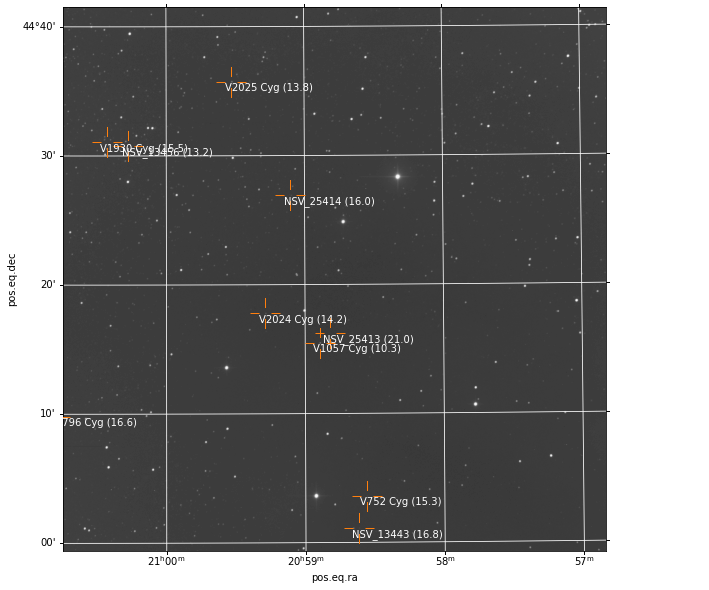

<Figure size 720x720 with 0 Axes>

48:R0:J383365
jid 383365: ()
26 August 2021 02:31:22 UTC
Filters: ('Luminance',)
Solving for 1A69FC25
solve-field -p -l 120 -O -L 1 -H 2 -u app -3 314.700000 -4 44.332778 -5 5 /tmp/field-solverxmg2msjy/tmpl2j8pdfk.fits


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [244]:
figsize(10,10)
for n, jid in enumerate(olst):
    if jid in (problematic | done):
        continue
    rid=0
    print(f"{n}:R{rid}:J{jid}", end='\r')
    if jid not in DB:
        print(f"{n}:R{rid}:J{jid}")
        try :
            process_job(jid)
        except TimeoutError:
            problematic |= {jid}
            continue
    done |= {jid}   

In [239]:
DB['problematic']=problematic
DB['done']=done
len(done), len(problematic)

(1351, 2)

In [136]:
jid = 333721
jid = 338617
jid = 327069
jid = 321992
jid = 300678
hdu = fits.open(OSO.get_obs(OSO.get_job(jid), cube=True, verbose=False))[0]
z = OSO.get_obs(OSO.get_job(jid), cube=False, verbose=False)
hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]

In [164]:
figsize(12,12)

In [201]:
DB['sequences']={}

Getting 58852707 from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


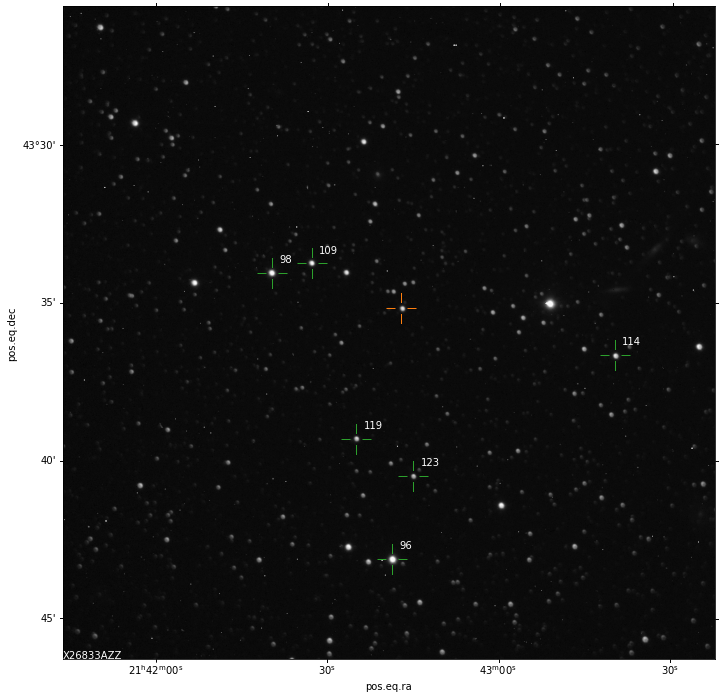

In [204]:
hdu = hdul[0]
data = hdu.data
w = WCS(solver.solve(hdu))
ax = subplot(projection=w)
p = SkyCoord('21:42:42.79 +43:35:09.9', unit=(u.hourangle, u.deg))
imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
plot(p.ra, p.dec, marker=marker, color='C1', ms=30, transform=ax.get_transform('world'))
plot_sequence('SS Cyg')

jid 300678: (SS Cyg)
19 August 2017 02:52:14 UTC
Filters: ('R', 'V', 'B')
Getting 58852707 from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


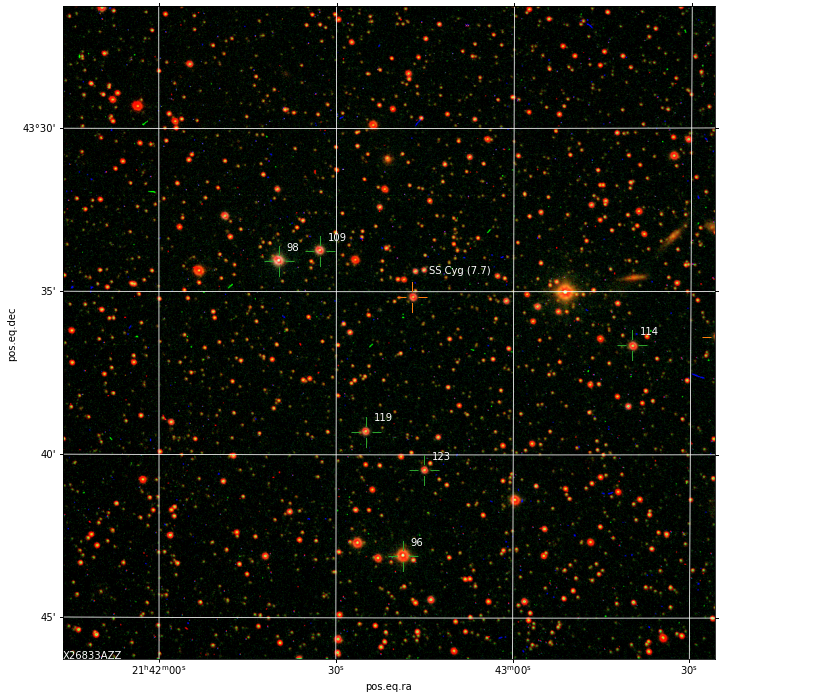

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [246]:
figsize(12,12)
process_job(300678, True, False)

In [249]:
VS['SS Cyg']

{'jobs': [300678]}

In [ ]:
solver.solve(hdul[0], tout=60)

In [ ]:
olst

In [ ]:
hud.header['FILTER'], hud.header['TELESCOP']

In [ ]:
def solve_field_upload(img, crop=((0,-32),(0,-32)), cache='.cache/wcs', 
                       set_center=True, force_solve=False):
    hdu = fits.open(img.name)[0]
    if hdu.verify_datasum()!=1:
        hdu.add_datasum()
    fn = f'{int(hdu.header["DATASUM"]):08X}.wcs'
    fp = os.path.join(cache,fn[0],fn[1],fn)
    if force_solve or not os.path.isfile(fp) :
        print('Solving for ', fp)
        try :
            settings = {'scale_type': 'ul',
                        'scale_units': 'arcsecperpix',
                        'scale_lower': 0.5,
                        'scale_upper': 2,
                       }
            if set_center :
                settings.update({'center_ra': hdu.header['RA']*15,
                                 'center_dec': hdu.header['DEC'],
                                 'radius': 1, 
                                 'parity': 0,
                                })

            wcs_header = ast.solve_from_image(img.name, force_image_upload=True, solve_timeout=120, **settings)
            if wcs_header :
                print('Success')
                wcs_header['NAXIS'] = 2
                wcs_header['NAXIS1'] = wcs_header['IMAGEW']
                wcs_header['NAXIS2'] = wcs_header['IMAGEH']
                try : 
                    os.makedirs(os.path.dirname(fp), exist_ok=True)
                    with open(fp, 'w') as fh:
                        wcs_header.totextfile(fp)
                except TypeError:
                    pass
            else :
                print('No solution')
        except ASTTimeoutError:
            print('Solver timeout')
            wcs_header=None
    else :
        print(f'Getting {fp} from cache')
        wcs_header=None
        from astropy.io.fits import Header
        with open(fp, 'r') as fh:
            wcs_header = Header.fromtextfile(fh)
    return wcs_header    

In [ ]:
def solve_field_list(hdu, crop=((0,-32),(0,-32)), cache='.cache/wcs', 
                set_center=True, force_solve=False, force_upload=False,
                minsrc=50, maxsrc=500):
    if hdu.verify_datasum()!=1:
        hdu.add_datasum()
    fn = f'{int(hdu.header["DATASUM"]):08X}.wcs'
    fp = os.path.join(cache,fn[0],fn[1],fn)
    if force_solve or not os.path.isfile(fp) :
        print('Solving for ', fp)
        data = hdu.data[crop[0][0]:crop[0][1],crop[1][0]:crop[1][1]]
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        sigma = 200
        for n in range(20) :
            daofind = DAOStarFinder(fwhm=8.0, threshold=sigma*std)
            sources = daofind(data - median)
            #print(sigma, sources)
            if sources is None or len(sources) < minsrc:
                sigma /= 2
            elif len(sources) > maxsrc:
                sigma *= 2
            else :
                break
        else :
            print(f'Cannot extract {minsrc} < n < {maxsrc} sources.')
            return None


        sources.sort('flux')
        sources.reverse()


        try :
            settings = {'scale_type': 'ul',
                        'scale_units': 'arcsecperpix',
                        'scale_lower': 0.5,
                        'scale_upper': 2,
                       }
            if set_center :
                settings.update({'center_ra': hdu.header['RA']*15,
                                 'center_dec': hdu.header['DEC'],
                                 'radius': 1, 
                                 'parity': 0,
                                })

            wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'], 
                                                    data.shape[0], data.shape[1],
                                                    solve_timeout=120,
                                                    **settings)
            if wcs_header :
                print('Success')
                wcs_header['NAXIS'] = 2
                wcs_header['NAXIS1'] = wcs_header['IMAGEW']
                wcs_header['NAXIS2'] = wcs_header['IMAGEH']
                try : 
                    os.makedirs(os.path.dirname(fp), exist_ok=True)
                    with open(fp, 'w') as fh:
                        wcs_header.totextfile(fp)
                except TypeError:
                    pass
            else :
                print('\nNo solution')
        except ASTTimeoutError:
            print('\nSolver timeout')
            wcs_header=None
    else :
        print(f'Getting {fp} from cache')
        wcs_header=None
        from astropy.io.fits import Header
        with open(fp, 'r') as fh:
            wcs_header = Header.fromtextfile(fh)
    return wcs_header

In [ ]:
OSO.get_job(olst[0])

In [ ]:

figsize(8, 8)
for nj, jid in enumerate(olst):
    #jid = int(OSO.get_request(int(rq['id']))['jid'][1:])
    job = OSO.get_job(jid)
    ctime = job['completion']
    print(f'{nj}:jid {jid} (', OSO.get_request(int(job['rid'].split()[0][1:]))['name'], f'):  {" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)    
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')
    if jid in DB :
        print('Done')
        display.clear_output(wait=True);
        continue
    hi = min(1, len(hdul)-1)
    try :
        wcs_head = solve_field_list(hdul[hi])
    except ASTTimeoutError:
        wcs_head = None
#    wcs_head = None
    if not wcs_head:
        try:
            img = OSO.get_obs(job, cube=True, verbose=False)
            wcs_head = solve_field_upload(img)
        except ASTTimeoutError:
            wcs_head = None
    if not wcs_head:
        try :
            wcs_head = solve_field_list(hdul[hi], set_center=False)
        except ASTTimeoutError:
            wcs_head = None
    if not wcs_head:
        try:
            img = OSO.get_obs(job, cube=True, verbose=False)
            wcs_head = solve_field_upload(img, set_center=False)
        except ASTTimeoutError:
            wcs_head = None
    if wcs_head :
        hdul[hi].add_datasum()
        fn = f'{int(hdul[hi].header["DATASUM"]):08X}.wcs'
        fp = os.path.join('.cache/wcs',fn[0],fn[1],fn)
        try : 
            os.makedirs(os.path.dirname(fp), exist_ok=True)
            with open(fp, 'w') as fh:
                wcs_head.totextfile(fp)
        except TypeError:
            pass
    if not wcs_head:
        print('Cannot solve image')
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
        show();
        continue
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
    for g in result:
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'

            #print(f'{name:12} {o["magMax"]:6.2f} {o.keys()}')
#             print(f'{name:12} {o["magMax"]:6.2f}')
    subplot(projection=w)
    grid(color='white', ls='solid')
    ax = gca()
    for g in result:
        #print(g)
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            try : 
                try :
                    radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                                     frame='fk5', unit=(u.hourangle, u.deg))
                except ValueError:
                    radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], 
                                     frame='fk5', unit=(u.deg, u.deg))
            except KeyError:
                    radec =  SkyCoord(o['_RA.icrs'] + o['_DE.icrs'], 
                                     frame='icrs', unit=(u.hourangle, u.deg))
#                     radec =  SkyCoord(o['RAB1950'] + o['DEB1950'], 
#                                      frame='fk4', unit=(u.hourangle, u.deg))
            ax.scatter(radec.ra.deg, radec.dec.deg, transform=ax.get_transform('icrs'), s=20, edgecolor='red', facecolor='none')
#             ax.text(radec.ra.deg, radec.dec.deg, f'  {name} ({o["magMax"]})', 
#                     transform=ax.get_transform('fk5'), color='red')
    display.clear_output(wait=True)
    print(f'{nj}:jid {jid} (', OSO.get_request(int(job['rid'].split()[0][1:]))['name'], f'):  {" ".join(ctime)}')
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')

    try :
        if len(hdul)==3:
            imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul]))
        else :
            data = hdul[hi].data[:-32,:-32]
            imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    except aa.MaxIterError:
        data = hdul[hi].data[:-32,:-32]
        imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    show()
    display.display(gcf());

In [ ]:
jid = 383576
img = OSO.get_obs(OSO.get_job(jid), cube=True, verbose=True)
solve_field_upload(img);

In [ ]:
rq = complete[0]
jid = int(OSO.get_request(int(rq['id']))['jid'][1:])

In [ ]:
jid = 383310
img = OSO.get_obs(OSO.get_job(jid), cube=True, verbose=True)
z = OSO.get_obs(OSO.get_job(jid), cube=False, verbose=True)

In [ ]:
solve_field_upload(img)

In [ ]:
hdul = fits.open(img.name)[0]

In [ ]:
hdul.fileinfo()

In [ ]:
hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]

In [ ]:
hdu = hdul[1]
for n, hdu in enumerate(hdul):
    print(n, hdu.header['FILTER'])

In [ ]:
w = solve_field(hdu)

In [ ]:
r, g, b = (hdu.data[:-32,:-32] for hdu in hdul)

In [ ]:
subplot(projection=WCS(w))
imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul],
                        black=1.15,
                        stretch=100,
                        Q=5
                       ))
grid(color='white', ls='solid')

In [ ]:
imshow(g, norm=simple_norm(g, 'asinh', asinh_a=0.1))

In [ ]:
f'{int(hdu.header["DATASUM"]):08X}'

In [ ]:
aa.register(b, g, detection_sigma=10)

In [ ]:
data = hdu.data[:-32,:-32]
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
norm=simple_norm(data, 'asinh', asinh_a=0.001)
daofind = DAOStarFinder(fwhm=4.0, threshold=200.*std)
sources = daofind(data - median)
sources.sort('flux')
sources.reverse()
len(sources)

In [ ]:
figsize(10,10)
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.)
imshow(data, cmap='gray', norm=norm, interpolation='nearest')
apertures.plot(color='yellow', lw=1.5, alpha=0.5);

In [ ]:
wcs_header['NAXIS']=2
wcs = WCS(wcs_header)
box = wcs.calc_footprint(wcs_header, axes=data.shape)
c = box.mean(axis=0)
s = box.max(axis=0) - box.min(axis=0)

In [ ]:
#cats = list(Vizier.find_catalogs('gcvs')) + list(Vizier.find_catalogs('vsx'))
cats = ['B/gcvs', 'B/vsx']
cats = 'B/gcvs'

In [ ]:
result = Vizier.query_region(catalog=cats, coordinates=SkyCoord(*c, unit='deg', frame='fk5'), width=f'{s[0]}deg', height=f'{s[1]}deg')
for g in result:
    for n, o in enumerate(g):
        if 'Name' in o.keys():
            name = o['Name']
        elif 'GCVS' in o.keys():
            name = ' '.join(o['GCVS'].split())
        elif 'NSV' in o.keys():
            name = f'NSV_{o["NSV"]}'

        print(f'{name:12} {o["magMax"]:6.2f}')

In [ ]:
figsize(14,14)
subplot(projection=wcs)
imshow(data, norm=norm)
grid(color='white', ls='solid')
ax = gca()
for g in result:
    for n, o in enumerate(g):
        if 'Name' in o.keys():
            name = o['Name']
        elif 'GCVS' in o.keys():
            name = ' '.join(o['GCVS'].split())
        elif 'NSV' in o.keys():
            name = f'NSV_{o["NSV"]}'
        else :
            name = f'VS_{n}'
        try :
            radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], frame='fk5', unit=(u.hourangle, u.deg))
        except ValueError:
            radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
        ax.scatter(radec.ra.deg, radec.dec.deg, transform=ax.get_transform('icrs'), s=20, edgecolor='red', facecolor='none')
        ax.text(radec.ra.deg, radec.dec.deg, f'  {name} ({o["magMax"]:.1f})', 
                transform=ax.get_transform('fk5'), color='red')
    

In [ ]:
figsize(10,10)
imshow((data),aspect='equal', norm=simple_norm(data, 'asinh', asinh_a=0.0005))

In [ ]:
#subplot(projection=wcs)
imshow(make_color_image([hdu.data[:-100,:-100] for hdu in hdul]))
#grid(color='white', ls='solid')

In [ ]:
def searchVS(h, cat='GCVS', caturl=None, maxSearchRadius=5):
    '''
    Search the area of the image in h (hdu, fits) for variable stars
    using the given catalogue. The cat imput parameter denotes the 
    catalogue:
    
    'GCVS' - use the General Catalogue of Variable Stars
    'VSX'  - use the AAVSO Variable Star Index
    'USER' - use the custom url passed in caturl parameter
    
    The maximum search radius is specified by maxSearchRadius (deg).
    
    Returns a list of VS in the circle with the frame inscribed in it.
    '''
    from pyvo import conesearch
    
    if cat=='GCVS' :
        caturl='http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=B/vsx&amp;'
    elif cat=='VSX' :
        caturl='http://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl?table=aavsovsx&amp;'
    else :
        caturl=caturl
    
    w=WCS(h)
    cen=w.all_pix2world(array([[h['NAXIS1'], h['NAXIS2']]])/2,0)[0]
    # Half of the hypotenuse of the frame = radius of the search
    rad=sqrt(sum((real(eigvals(w.wcs.cd))*array([h['NAXIS1'], h['NAXIS2']]))**2))/2
    # Clamp to reasonable size
    rad=min(rad, maxSearchRadius)
    r=conesearch(caturl,pos=list(cen),radius=rad)
    return r

In [ ]:
searchVS(wcs_header)

In [ ]:
wcs_header['NAXIS1']=wcs_header['IMAGEW']
wcs_header['NAXIS2']=wcs_header['IMAGEH']

In [ ]:
def analyseJob(scope, jid, cat='GCVS'):
    obs=scope.get_job(jid)
    if obs['type']!='SSBODY' :
        print jid, obs['filter'], obs['exp'], obs['type'], obs['oid']
        
        z=scope.get_obs(obs,cube=False)
        
        hdul=[fits.open(BytesIO(z.read(name))) for name in z.namelist()]

        for h,f in zip(hdul,obs['filter']):
            h[0].header['FILTER']=f

        shdul=[scope.solveField(h[0],name=str(jid)) for h in hdul]
        for n,h in enumerate(shdul):
            print 'Filter: ',hdul[n][0].header['FILTER'],
            if h is None :
                print 'Unable to solve the field!'
                imshow(sqrt(hdul[n][0].data),aspect='equal')
                continue
            w=wcs.WCS(h[0].header)
            imshow(sqrt(h[0].data),aspect='equal')
            plot(h[0].header['NAXIS1']/2,h[0].header['NAXIS2']/2,'r+',ms=30)
            if obs['type']=='RADEC':
                obj=SkyCoord(obs['oid'], unit=(u.hourangle, u.deg))
            else :
                obj=SkyCoord.from_name(obs['type']+obs['oid'])
            pix=w.all_world2pix(array([[obj.ra.deg,obj.dec.deg]]),0)[0]
            plot(pix[0],pix[1],'r+',ms=20)
            plot(pix[0],pix[1],'ro',fillstyle='none', ms=12)
            r=searchVS(h)
            print "Number of VS:", len(r)
            for s in r:
                vsname='%(Name)-25s' % s
                # filter out NSV and VSX hits (leave just GCVS marked stars)
                if vsname.find('NSV')<0 and vsname.find('VSX')<0 :
                    pix=w.all_world2pix(array([[s.ra,s.dec]]),0)[0]
                    # reject out of frame stars
                    if 0 < pix[0] < h[0].header['NAXIS1'] and 0 < pix[1] < h[0].header['NAXIS2'] :
                        plot(pix[0],pix[1],'ro',fillstyle='none')
                        annotate(vsname, pix, xytext=(5,-7), textcoords='offset points', color='y')
                        print '%(Name)25s %(Period)12.6f %(min)6.2f - %(max)6.2f ' % s
            xlim(0,h[0].header['NAXIS1'])
            ylim(0,h[0].header['NAXIS2'])
            show()
        print
    